### Import all the libraries.

In [2]:
import tensorflow as tf
import pathlib
import random
import IPython.display as display
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt


### Define all the functions.

In [3]:
def downloadUnzip(fileName, sourceURL, dest_dir):
    ''' 
        This function downloads the files from the source and unzips thems and stores them to a specified destination.
        
        Args:
            fileName(str): Name of file from source
            sourceURL(str): url of the source to download from
            dest_dir(str): Path on local to store the downloaded data
            
        Returns: Path of saved files on local to access
    '''
    
    data_root = tf.keras.utils.get_file(fileName, sourceURL, untar=True, cache_dir=dest_dir,extract=True)
    data_root = pathlib.Path(data_root)
    return data_root

def get_all_paths(data_root):
    ''' 
        This function allows us to get all image paths and randomly shuffles them.
        
        Args:
            data_root(str): root directory where data has been downloaded.
            
        Returns: Path all images
    '''
    all_image_paths = list(data_root.glob('*/*'))
    all_image_paths = [str(path) for path in all_image_paths]
    random.shuffle(all_image_paths)
    return all_image_paths

def get_path_and_label(data_root):
    ''' 
        This function helps us get the path and label of each image.
        
        Args:
            data_root(str): root directory where data has been downloaded.
            
        Returns: Path and label
    '''
    all_image_paths = get_all_paths(data_root)
    X = [p.rsplit('/', 2)[1] + '/' + p.rsplit('/', 1)[1] for p in all_image_paths]
    y = [p.rsplit('/', 1)[0].rsplit('/', 1)[1] for p in all_image_paths]
    return X, y

def caption_image(image_path):
    ''' 
        This function helps us caption each image. 
        
        Args:
            image_path(str): path of image to be captioned
            
        Returns: Path and caption
    '''
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return image_rel, str(image_rel).split('/')[0]

def display_image_and_caption(data_root):
    ''' 
        This function helps display the image. 
        
        Args:
            data_root(str): root directory where data has been downloaded.
    '''
    for n in range(3):
        all_image_paths = get_all_paths(data_root)
        image_path = random.choice(all_image_paths)
        display.display(display.Image(image_path))
        imPath, label = caption_image(image_path)
        print(label)
        print()

def split_data(data_root, test_size, valid_size):
    ''' 
        This function helps us split data into train, test and validation with ratio of 60:20:20

        Args:
            data_root(str): root directory where data has been downloaded.
            
        Returns: A list of list of all the paths for each set of dataset.
    '''
    X, y = get_path_and_label(data_root)
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=None)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_temp, y_train_temp, test_size=valid_size, stratify=y_train_temp, random_state=None)
    X_data = [X_train, X_test, X_valid]
    return X_data

def write_dataset_to_file(filenames, X_data, root_file):
    ''' 
        This function writes all the datasets (train, test, validation) to files in a location locally.

        Args:
            data_root(str): root directory where data has been downloaded.
            filenames(list): list filenames ['trainData', 'testData', 'validataionData']
    ''' 
    for d, l in zip(X_data, filenames):
        with open(root_file+l+'.txt', 'w') as f:
            for item in d:
                f.write("%s\n" % item)

def class_dictionary(data_root):
    ''' 
        This function make the class labels a dictionary as follows:
        {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}
        
        Args:
            data_root(str): root directory where data has been downloaded.
    '''
    all_image_paths = get_all_paths(data_root)
    label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
    label_to_index = dict((name, index) for index,name in enumerate(label_names))
    all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                        for path in all_image_paths]
    return label_to_index

# The following functions can be used to convert a value to a type compatible
# with tf.Example.
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def image_example(image_string, label, filename):
    '''
        This function Create a dictionary with features that may be relevant.
        
        Args:
            image_string(bytes): image as bytes
            label(str): Label of image
            filename(str): filename of image
            
        Returns: Tfrecords 
    '''
    image_shape = tf.image.decode_jpeg(image_string).shape
    for lab, val in label_to_index.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
        if lab == label:
            label_no = val
    feature = {
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
        'label_num': _int64_feature(label_no),
        'image_raw': _bytes_feature(image_string),
        'filename' : _bytes_feature(str.encode(filename)),
        'label': _bytes_feature(str.encode(label)),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecords(data_dir, split_path, output_path):
    '''
        This function writes to tfrecords
        
        Args:
            data_dir(str): path of directory where images are
            split_path(str): path where split(train, test, validation) data path file is
            output_path(str): path of where to store the tfrecords
    '''
    with tf.io.TFRecordWriter(output_path) as writer:
        f = open(split_path, "r")
        for line in f:
            label = line.split('/')[0]
            image_string = open(data_dir+line.rstrip('\n'), 'rb').read()
            tf_example = image_example(image_string, label, line)
            writer.write(tf_example.SerializeToString())

def create_image_feature_description():
    '''
        This function create a dictionary describing the features.
    
        Returns: Dictionary of image feature descriptions
    '''
    image_feature_description = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64),
        'label_num': tf.io.FixedLenFeature([], tf.int64),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'filename' : tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.string),
    }
    return image_feature_description

def parse_fn(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
    image_feature_description = create_image_feature_description()
    parsed = tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.image.decode_image(parsed["image_raw"])
    image = tf.reshape(image, (parsed['height'], parsed['width'], 3))
    image = tf.image.resize(image, (160, 160))
    image = (image/127.5)-1
    return image, parsed["label_num"]

def make_dataset(datasetPath, shuffle_buffer_size, batch_size):
    '''
        This function makes dataset for each split data.
        
        Args:
            datasetPath(str): path of where tfrecords are saved
            shuffle_buffer_size(int): size of shuffle buffer
            batch_size(int): size of batch
        
        Returns: dataset
    '''
    dataset = tf.data.TFRecordDataset(datasetPath)
    dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
    dataset = dataset.repeat()
    dataset = dataset.map(map_func=parse_fn)
    dataset = dataset.batch(batch_size=batch_size)
    return dataset

### Download and unzip the data calling 'downloadUnzip( )'

In [4]:
fileName = 'flower_photos'
dest_dir = '/home/aakanksha/new_dataset'
sourceURL = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_root = downloadUnzip(fileName, sourceURL, dest_dir)

### Display Image & Caption calling 'display_image_and_caption( )'

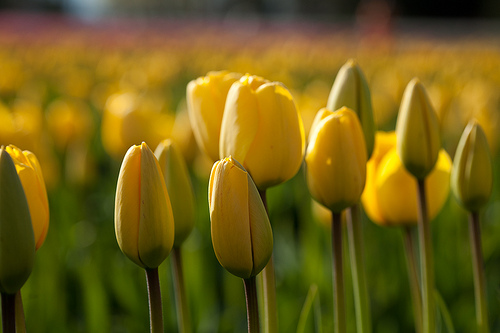

tulips



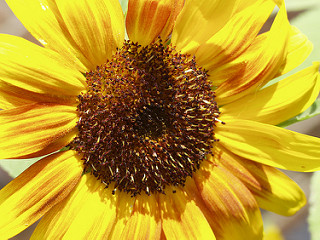

sunflowers



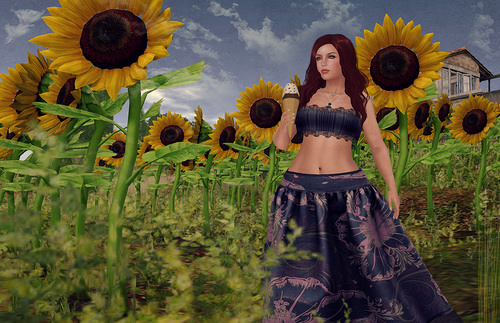

sunflowers



In [5]:
display_image_and_caption(data_root)

### Split data into training, validation, testing by calling 'split_data()'

In [6]:
test_size = 0.20
valid_size = 0.20
X_data = split_data(data_root, test_size, valid_size)

### Make a dictionary of labels

In [7]:
label_to_index = class_dictionary(data_root)

### Write the split data (above function) into three different files by calling 'write_dataset_to_file()'

In [8]:
filenames = ['trainData', 'testData', 'validataionData']
root_file = ''
write_dataset_to_file(filenames, X_data, root_file)

### Write data into tfrecords by calling 'write_tfrecords()'
This can be called three different times, for each training, testing and validation sets.

In [9]:
data_dir = '/home/aakanksha/datasets/flower_photos/'
#split_path = ['trainData.txt', 'testData.txt', 'validataionData.txt']
#output_path = ['trainImages.tfrecords', 'validImages.tfrecords', 'testImages.tfrecords']
write_tfrecords(data_dir, 'trainData.txt', 'trainImages.tfrecords') 
write_tfrecords(data_dir, 'validataionData.txt', 'testImages.tfrecords') 
write_tfrecords(data_dir, 'testData.txt', 'validImages.tfrecords') 


### Dataset for each training, testing and validation are made with a specified batch size and shuffle buffer size by calling 'make_dataset()' three times

In [10]:
shuffle_buffer_size = 1000
batch_size = 32
ds_train = make_dataset('trainImages.tfrecords', shuffle_buffer_size, batch_size)
ds_valid = make_dataset('validImages.tfrecords', shuffle_buffer_size, batch_size)
ds_test = make_dataset('testImages.tfrecords', shuffle_buffer_size, batch_size)

W0711 12:55:29.715070 139823273346880 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


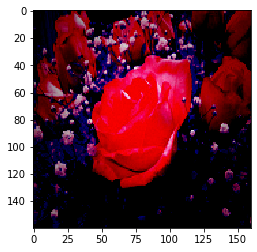

2


In [11]:
for images, labels in ds_train.take(1):
    image = images.numpy()[0, :, :, :]
    label = labels.numpy()[0]
    plt.imshow(image, interpolation='nearest')
    plt.show()
    #print(image)
    
    print(label)

In [12]:
num_train = len(X_data[0])
num_test = len(X_data[1])
num_val = len(X_data[2])
tr_steps_per_epoch = num_train//batch_size
val_steps_per_epoch = num_val//batch_size
te_steps_per_epoch = num_test//batch_size

### Feature Extraction 

In [13]:
IMG_SIZE = 160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')


In [14]:
feature_batch = base_model(images)
print(feature_batch.shape)


(32, 3, 3, 2048)


In [15]:
base_model.trainable = False

In [16]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 79, 79, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 79, 79, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

__________________________________________________________________________________________________
mixed4 (Concatenate)            (None, 8, 8, 768)    0           activation_30[0][0]              
                                                                 activation_33[0][0]              
                                                                 activation_38[0][0]              
                                                                 activation_39[0][0]              
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 8, 8, 160)    122880      mixed4[0][0]                     
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 8, 8, 160)    480         conv2d_44[0][0]                  
__________________________________________________________________________________________________
activation

### Adding a classification head 

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [18]:
prediction_layer = tf.keras.layers.Dense(5)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 5)


In [19]:
model = tf.keras.Sequential([base_model, global_average_layer, prediction_layer])

In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [22]:
initial_epochs = 10
validation_steps = 20
loss0, accuracy0 = model.evaluate(ds_valid, steps = validation_steps)

20/20 [==============================] - 12s 613ms/step - loss: 10.0179 - accuracy: 0.1578


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 10.02
initial accuracy: 0.16


In [24]:
history = model.fit(ds_train, epochs=initial_epochs, steps_per_epoch=tr_steps_per_epoch,validation_steps=val_steps_per_epoch, validation_data=ds_valid)

Epoch 1/10


W0711 12:55:53.721571 139823273346880 deprecation.py:323] From /home/aakanksha/venv/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


73/73 [==============================] - 54s 742ms/step - loss: 6.0107 - accuracy: 0.2453 - val_loss: 5.6844 - val_accuracy: 0.1354
Epoch 2/10
73/73 [==============================] - 52s 710ms/step - loss: 2.8087 - accuracy: 0.2384 - val_loss: 2.1242 - val_accuracy: 0.1302
Epoch 3/10
73/73 [==============================] - 55s 758ms/step - loss: 1.9278 - accuracy: 0.2389 - val_loss: 1.6799 - val_accuracy: 0.1215
Epoch 4/10
73/73 [==============================] - 52s 716ms/step - loss: 1.7455 - accuracy: 0.2491 - val_loss: 1.6393 - val_accuracy: 0.1285
Epoch 5/10
73/73 [==============================] - 54s 735ms/step - loss: 1.6914 - accuracy: 0.2658 - val_loss: 1.6399 - val_accuracy: 0.1372
Epoch 6/10
73/73 [==============================] - 54s 735ms/step - loss: 1.6600 - accuracy: 0.2517 - val_loss: 1.6395 - val_accuracy: 0.1545
Epoch 7/10
73/73 [==============================] - 55s 748ms/step - loss: 1.6214 - accuracy: 0.2530 - val_loss: 1.6387 - val_accuracy: 0.1510
Epoch 8/10

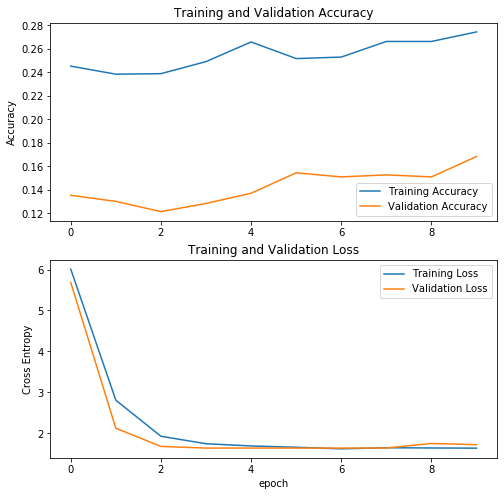

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


### Fine Tuning

In [26]:
base_model.trainable = True

In [27]:
print("Number of layers in the base model:", len(base_model.layers))

Number of layers in the base model: 311


In [28]:
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [29]:
model.compile(loss='sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10), metrics=['accuracy'])

In [30]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 19,636,613
Non-trainable params: 2,176,416
_________________________________________________________________


In [31]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(ds_train, epochs=total_epochs,
                         initial_epoch=initial_epochs, steps_per_epoch=tr_steps_per_epoch,validation_steps=val_steps_per_epoch,
                         validation_data=ds_valid)

Epoch 11/20
73/73 [==============================] - 194s 3s/step - loss: 1.6023 - accuracy: 0.3065 - val_loss: 1.8139 - val_accuracy: 0.2639
Epoch 12/20
73/73 [==============================] - 121s 2s/step - loss: 1.5030 - accuracy: 0.4114 - val_loss: 1.8306 - val_accuracy: 0.3003
Epoch 13/20
73/73 [==============================] - 121s 2s/step - loss: 1.4028 - accuracy: 0.4897 - val_loss: 1.8365 - val_accuracy: 0.4062
Epoch 14/20
73/73 [==============================] - 121s 2s/step - loss: 1.2424 - accuracy: 0.5599 - val_loss: 1.7926 - val_accuracy: 0.5052
Epoch 15/20
73/73 [==============================] - 120s 2s/step - loss: 1.1092 - accuracy: 0.6263 - val_loss: 1.7223 - val_accuracy: 0.5712
Epoch 16/20
73/73 [==============================] - 121s 2s/step - loss: 0.9808 - accuracy: 0.6802 - val_loss: 1.7356 - val_accuracy: 0.6198
Epoch 17/20
73/73 [==============================] - 130s 2s/step - loss: 0.8836 - accuracy: 0.7290 - val_loss: 1.8572 - val_accuracy: 0.6667
Epoch 

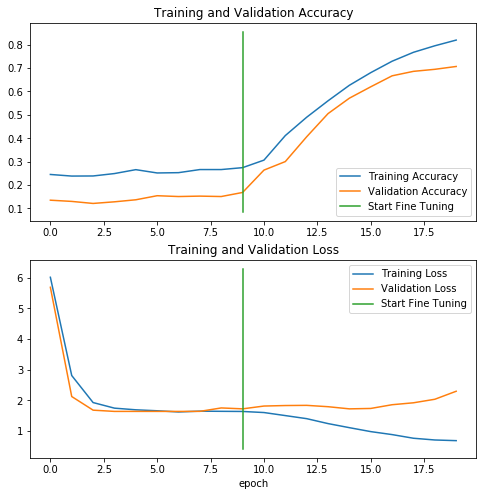

In [32]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()